# Análisis de tendencias

## Carga de las librerías de Python necesarias


In [1]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'statsmodels'

## Extracción de datos desde SQL Server

In [10]:
path="C:\\Users\\Desarrollador XPD\\Documents\\Anaconda\\portafolios\\ecommerce"
df= pd.read_csv(path+"\\forecast.csv")
 
df=df.dropna()
df.head()

,año,mes,ventas
0,2011,5,567020.95
1,2011,6,507096.47
2,2011,7,2292182.88
3,2011,8,2800576.17
4,2011,9,554791.61


In [11]:


df['Date'] = pd.to_datetime(df['mes'].astype(str) + '-' + df['año'].astype(str), format='%m-%Y')
df.head()

,año,mes,ventas,Date
0,2011,5,567020.95,2011-05-01
1,2011,6,507096.47,2011-06-01
2,2011,7,2292182.88,2011-07-01
3,2011,8,2800576.17,2011-08-01
4,2011,9,554791.61,2011-09-01


In [12]:
df_forecasting = df.groupby('Date')['ventas'].sum().reset_index()
df_forecasting['Date'] = pd.to_datetime(df_forecasting['Date'])
df_forecasting = df_forecasting.sort_values(by='Date')

df_forecasting.fecha = pd.to_datetime(df_forecasting.Date)

df_forecasting.set_index("Date", inplace=True)   


df_forecasting.tail(10)


,ventas
Date,
2013-09-01,5083505.34
2013-10-01,5374375.94
2013-11-01,3694668.00
2013-12-01,4560577.10
2014-01-01,4798027.87
2014-02-01,1478213.29
2014-03-01,8097036.31
2014-04-01,1985886.15
2014-05-01,6006183.21


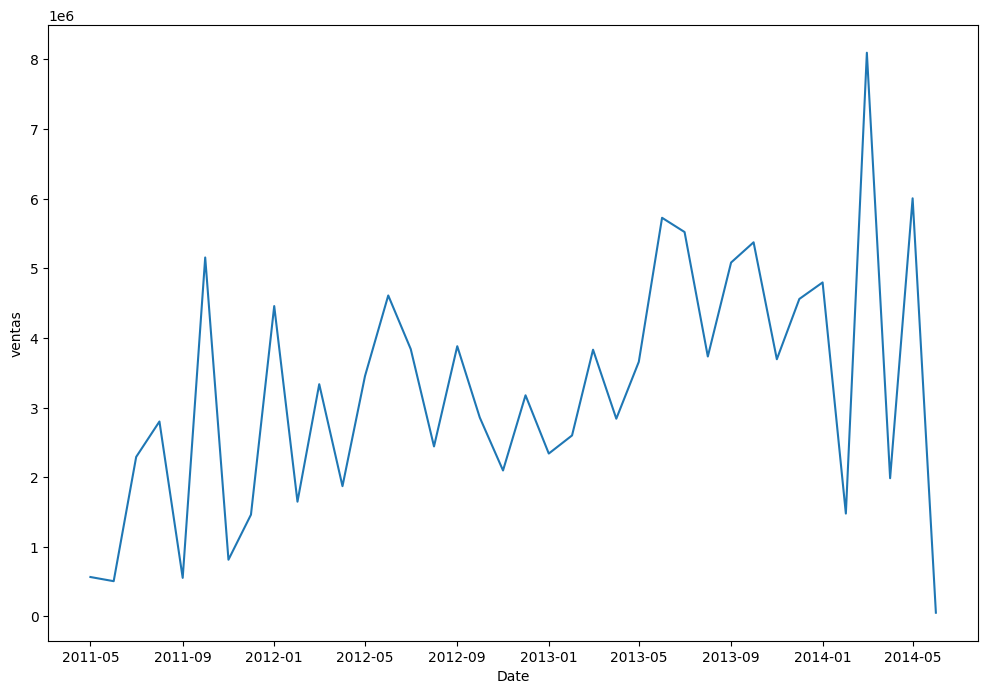

In [13]:
plt.plot(df_forecasting['ventas'])
plt.xlabel('Date')
plt.ylabel('ventas')
plt.show()

El gráfico muestra fluctuaciones en las ganancias de la venta de productos entre 2011 y 2014, con picos significativos en ciertos meses y caídas pronunciadas en otros. Esto sugiere una estacionalidad en las ventas o la influencia de factores externos que afectan la demanda. 

In [14]:
def test_estacionariedad(serie):
    result = adfuller(serie)
    print(f'ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    if result[1] <= 0.05:
        print('La serie es estacionaria')
    else:
        print('La serie no es estacionaria')

test_estacionariedad(df_forecasting.ventas)

ADF: -3.3620
p-value: 0.0123
Valores críticos:
   1%: -3.6267
   5%: -2.9460
   10%: -2.6117
La serie es estacionaria


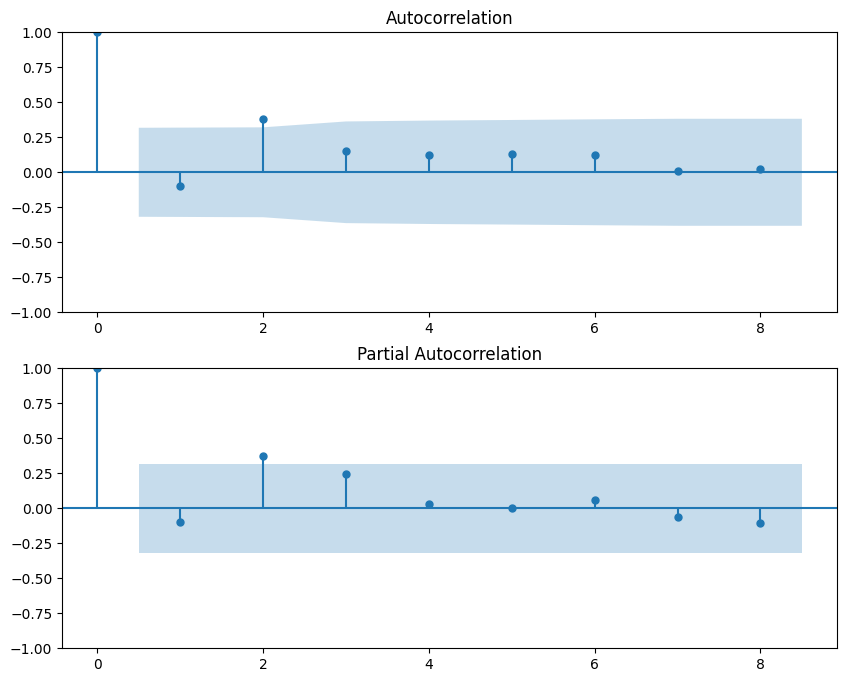

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
plot_acf(df_forecasting['ventas'], ax=ax1, lags=8)
plot_pacf(df_forecasting['ventas'], ax=ax2, lags=8)
plt.show()

In [16]:
result = seasonal_decompose(df_forecasting['ventas'], model='additive', period=12)


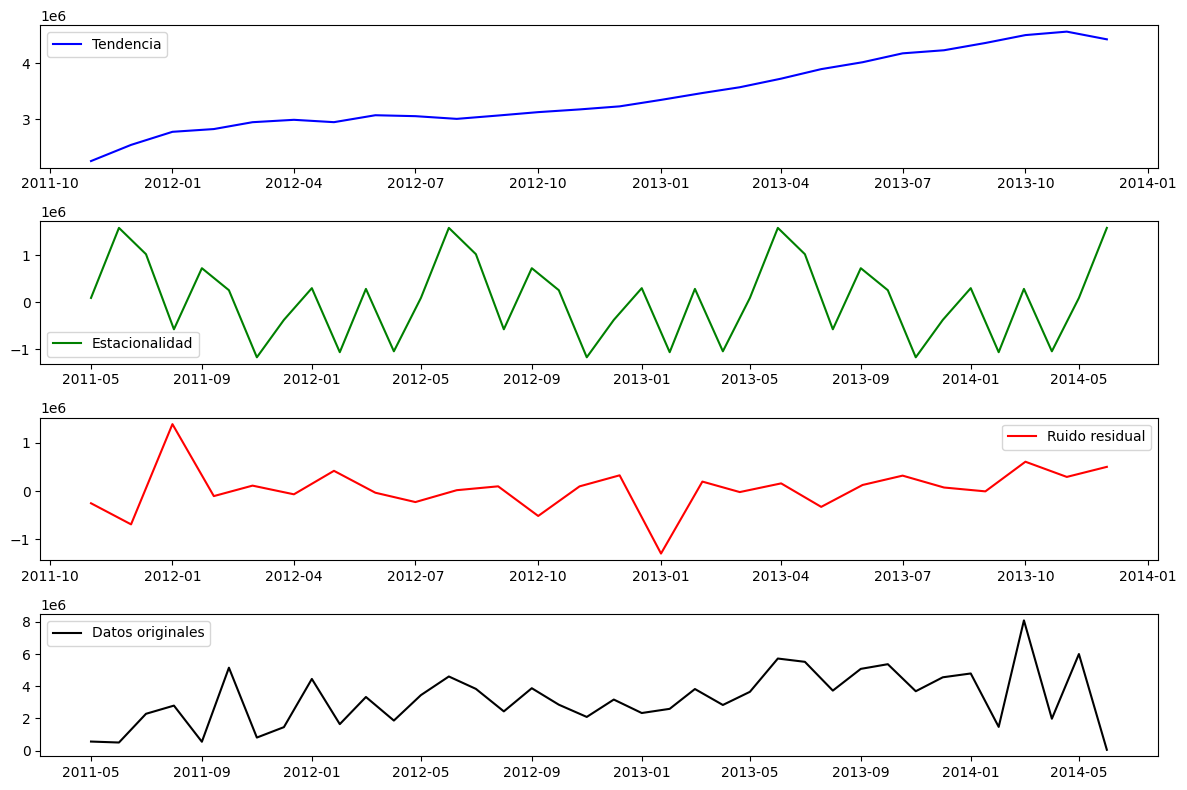

In [17]:
plt.subplot(411)
plt.plot(result.trend, label='Tendencia', color='blue')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(result.seasonal,label='Estacionalidad', color='green')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(result.resid, label='Ruido residual', color='red')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(df_forecasting['ventas'], label='Datos originales', color='black')
plt.legend(loc='best')

# Ajustar los espacios entre las gráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()

La línea de tendencia muestra un ascenso constante y gradual de octubre 2011 a enero 2014, sin giros abruptos ni estancamientos.

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar el modelo ARIMA
model = ARIMA(df_forecasting['ventas'], order=(1, 1, 1))  # Ajusta los parámetros según sea necesario
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 ventas   No. Observations:                   38
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -580.052
Date:                Tue, 12 Aug 2025   AIC                           1166.104
Time:                        09:34:58   BIC                           1170.937
Sample:                    05-01-2011   HQIC                          1167.808
                         - 06-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6483      0.170     -3.819      0.000      -0.981      -0.316
ma.L1         -0.5167      0.182     -2.846      0.004      -0.873      -0.161
sigma2      2.285e+12   3.28e-14   6.96e+25      0.0

In [27]:
forecast = model_fit.forecast(steps=3)
print(forecast)

2014-07-01   5667064.15
2014-08-01   2027975.01
2014-09-01   4387350.71
Freq: MS, Name: predicted_mean, dtype: float64


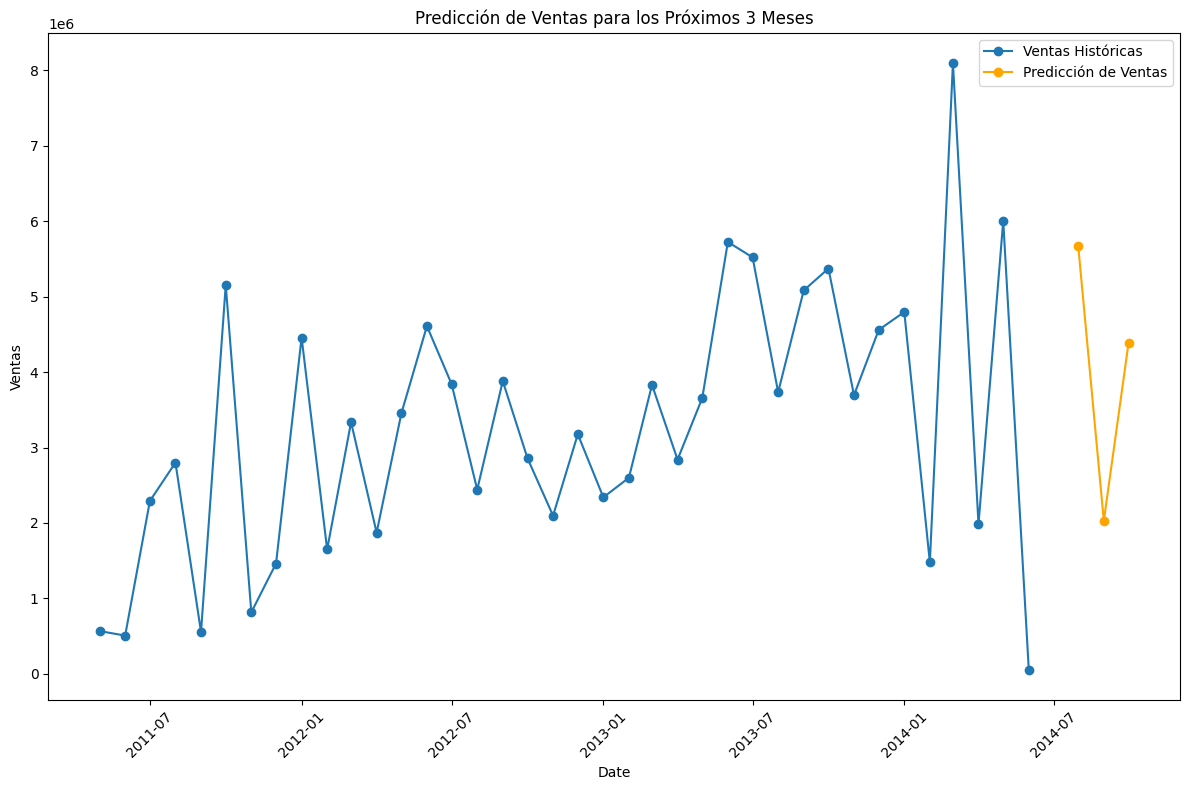

In [29]:

# Verifica el contenido de forecast_df
# Crear un rango de fechas para las predicciones
forecast_index = pd.date_range(start=df_forecasting.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')

# Graficar
plt.figure()
plt.plot(df_forecasting.index, df_forecasting['ventas'], label='Ventas Históricas', marker='o')
plt.plot(forecast_index, forecast, label='Predicción de Ventas', marker='o', color='orange')
plt.title('Predicción de Ventas para los Próximos 3 Meses')
plt.xlabel('Date')
plt.ylabel('Ventas')
plt.legend()
# plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Se espera un crecimiento ligero y sostenido en los próximos tres meses, manteniéndose por encima del nivel actual sin caídas abruptas. La variabilidad prevista es reducida, lo que minimiza el riesgo de desvíos significativos respecto a la proyección.

In [83]:
from statsmodels.tsa.stattools import adfuller
import itertools

# Función para evaluar modelos ARIMA
def evaluate_models(df, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    best_model = None
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(df['ventas'], order=(p, d, q))
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, d, q)
                best_model = model_fit
        except:
            continue
            
    return best_order, best_model

# Definir rangos de p, d y q
p_values = range(0, 9)  # Puedes ajustar este rango
d_values = [1]          # Generalmente 1
q_values = range(0, 9)  # Puedes ajustar este rango

# Evaluar modelos
best_order, best_model = evaluate_models(df_forecasting, p_values, d_values, q_values)

# Mostrar el mejor modelo
print(f"Mejor orden ARIMA: {best_order}")
print(f"AIC del mejor modelo: {best_model.aic}")

Mejor orden ARIMA: (1, 1, 1)
AIC del mejor modelo: 1166.1044664366325
